# Workflow Pipelines | Lecture 1

In [4]:
import pandas as pd
import ssl; ssl._create_default_https_context = ssl._create_stdlib_context

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
    header=None
)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df.shape

(569, 32)

In [7]:
# assign features to array & transform labels (initial labels are m and b)
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

# label encoder
le = LabelEncoder()
y=le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [8]:
# divide data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)

## Pipelines

allows us to use the same methods of scaling, dimensionality reduciton, learning algorithm and predictive model on the training data and all but fitting and learning algorthm on our test data.

In [9]:
# pipeline to scale and dimensionality reduciton and train
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'test accuracy: {round(pipe_lr.score(X_test, y_test), 4)}')

test accuracy: 0.9561


# Validation Data Methods | Lecture 2

when we're adjusting hyperparameters we are going to be running our models multiple times. Our models can become sensitive if we keep running it on the same data.

## HoldOut Method

we make a simple split into training and test data. However, with the holdout method we take part of the training data and use it as validation data. Validation data is what we use each time we adjust a hyperparamter. we use validation set as our test set and hold out the actual test set till later. However, this can be inefficient because we've use the validation set multiple times.

## K-Fold Cross-Validation Method

The most common - k can be any value. We're taking the training set, splitting into K iterations. common value is 10. in each iteration we use 1 grouping as the test data (validation data), then grouping changes with each iteration of training and testing. Then to determine the error we average the error of each iteration.

This is used to generalize but also to tune hyperparameters.

In [10]:
# strategied k-fold
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

# empty list to hold error scores
scores = []
for k, (train, test), in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'fold: {np.bincount(y_train[train])}, {round(score, 3)}')

fold: [256 153], 0.935
fold: [256 153], 0.935
fold: [256 153], 0.957
fold: [256 153], 0.957
fold: [256 153], 0.935
fold: [257 153], 0.956
fold: [257 153], 0.978
fold: [257 153], 0.933
fold: [257 153], 0.956
fold: [257 153], 0.956


In [11]:
print(f'CV: {round(np.average(scores), 3)}, std: {round(np.std(scores), 3)}')

CV: 0.95, std: 0.014


### Less verbose approach

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    cv=10,
    n_jobs=1
    )

print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {round(np.mean(scores), 3), round(np.std(scores), 3)}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: (0.95, 0.014)


## Two Variations

- Lean-one-out-cross-validation
    - used on small data sets
    - number of folds equals number of training samples

- Nested
    - we have our original set
    - create training and test folds
    - within a training set we create training and validation folds



# Understanding Bias & Variance | Lecture 3

## Understanding & Measuring Generalization

- bias
    - how well does your model fit the observed data?

- variance
    - how robust is the model to the chosen training set?

### Bias variance tradeoff

- the total expected error is $\text{bias}^2+\text{variance}$ is the tradeoff between the two
    - when variance is strong it means we're overfitting
    - when bias dominates, it is called underfitting

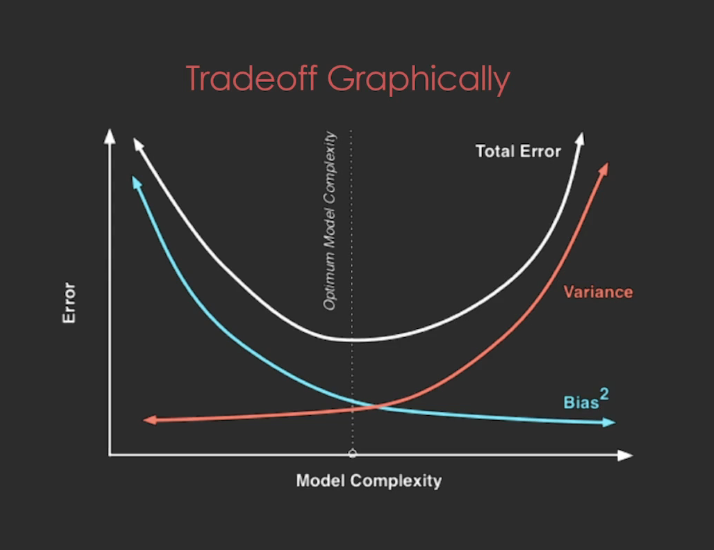

as the model becomes more complex, the square of the bias decreases but the variance increases. We are looking for optimal model complexity

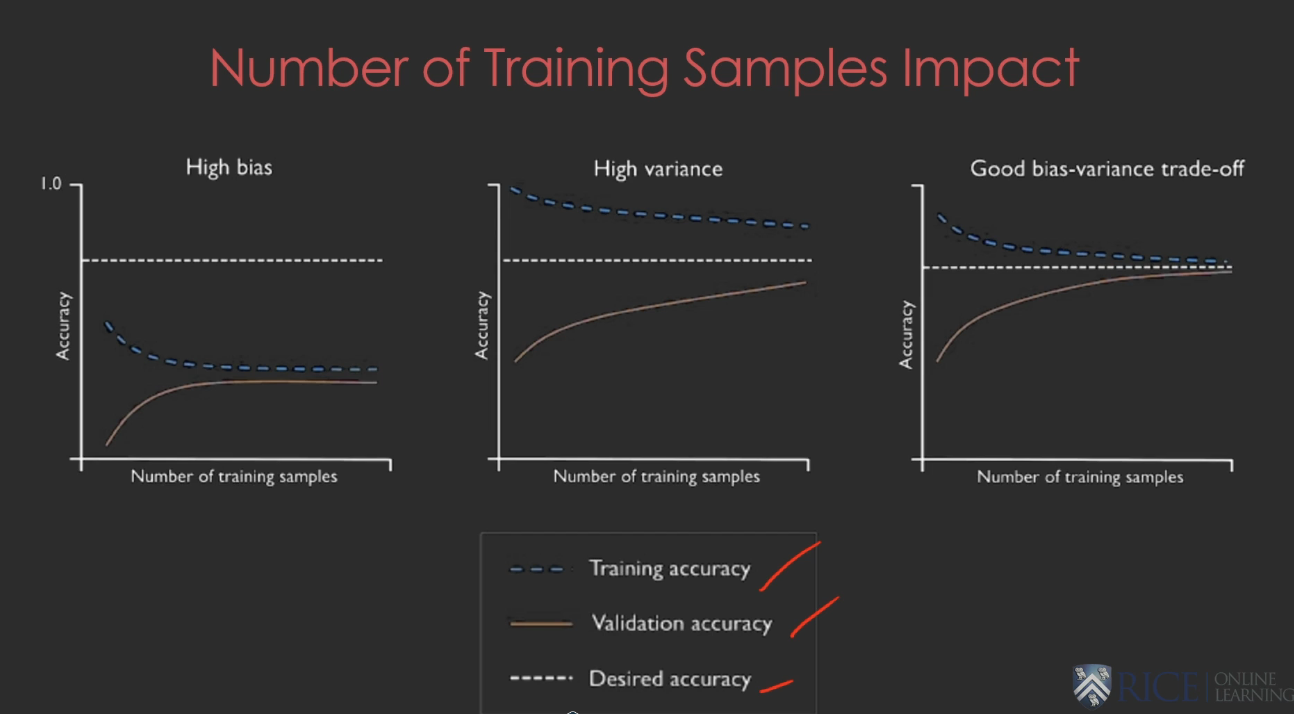

- when we have high bias, our training accuracy starts out higher and as we icnrease training samples it levels off

## Learning Curve Function in scikit-learn

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1, max_iter=1000)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

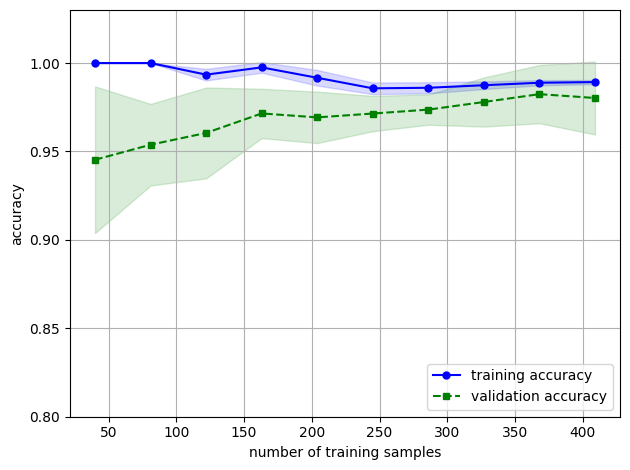

In [14]:
# plotting
plt.plot(train_sizes, train_mean,
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, 
                 color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(
    train_sizes, 
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15,
    color='green'
)

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## Validation Curve in scikit-learn

In [15]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr, 
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

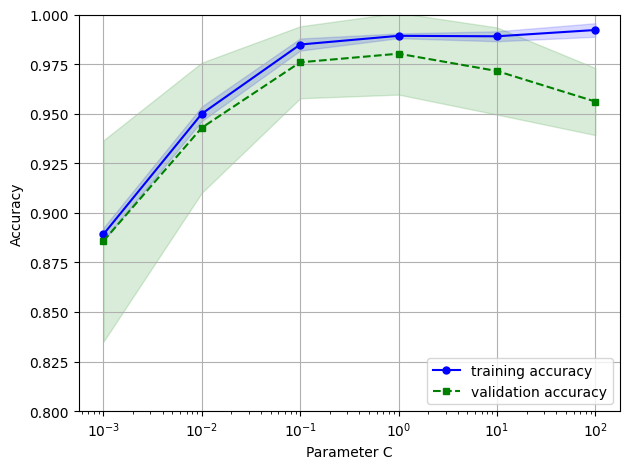

In [16]:
plt.plot(
    param_range, 
    train_mean,
    color='blue',
    marker='o',
    markersize=5,
    label='training accuracy'
)

plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color='blue'
)

plt.plot(
    param_range,
    test_mean,
    color='green',
    linestyle='--',
    marker='s',
    markersize=5,
    label='validation accuracy'
)

plt.fill_between(
    param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15,
    color='green'
)

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

# Fine Tuning & Model Selection | Lecture 4

## Grid Search
Brute force - exhaustive - expensive search

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

param_range = [
    0.0001,
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0
]

param_grid = [
    {'svc__C': param_range,
     'svc__kernel': ['linear']},
    {'svc__C': param_range,
     'svc__gamma': param_range,
     'svc__kernel': ['rbf']}
]

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


- we are using this method while we're training the model

## Confusion Matrix

- look at predicted vs actual

| True Positive | False Negative |
|:--- | :--- |
| False Positive | True Negative |

In [21]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


## Related Metrics

- sometimes we don't want to look at just the confusion matrix

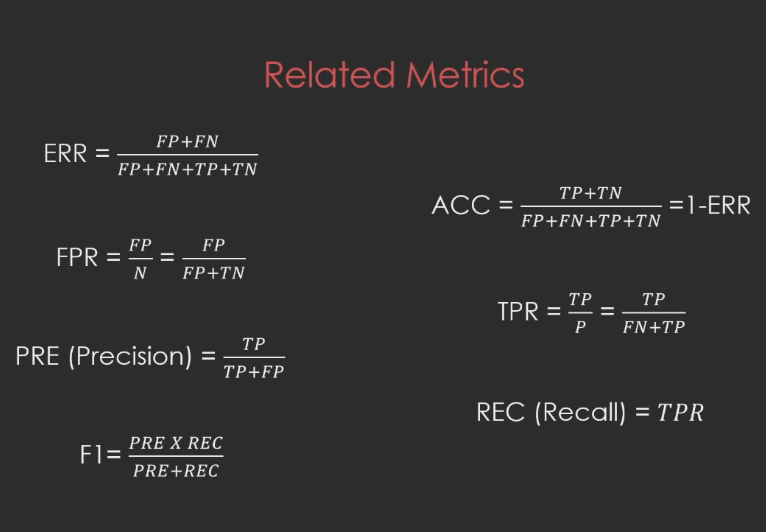

## Precision & Recall & F1 Metrics

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision: {precision_score(y_true=y_test, y_pred=y_pred)}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_pred)}')
print(f'F1: {f1_score(y_true=y_test, y_pred=y_pred)}')

Precision: 0.975609756097561
Recall: 0.9523809523809523
F1: 0.963855421686747


- need to compare these metrics against our model

## Changing the scorer & the positive class

In [25]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [
    {'svc__C': c_gamma_range,
     'svc__kernel': ['linear']},
     {'svc__C': c_gammaa_range,
      'svc__gamma': c_gammaa_range,
      'svc__kernel': ['rbf']}
]

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring=scorer,
    cv=10,
    n_jobs=-1
)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## Receiver Operating Characteristic (ROC)

- graphical plot that illistrates the diagnostic ability of a binary classifier system as its discrimination theshold is varied

- created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various theshold settings

- diagonal is considered guessing

- top left is perfect

- determine the area under the curve to determine performance

## Code for ROC

/var/folders/hw/f8pnpzm163q0j3yww182vmgm0000gn/T/ipykernel_79183/113336529.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/var/folders/hw/f8pnpzm163q0j3yww182vmgm0000gn/T/ipykernel_79183/113336529.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/var/folders/hw/f8pnpzm163q0j3yww182vmgm0000gn/T/ipykernel_79183/113336529.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


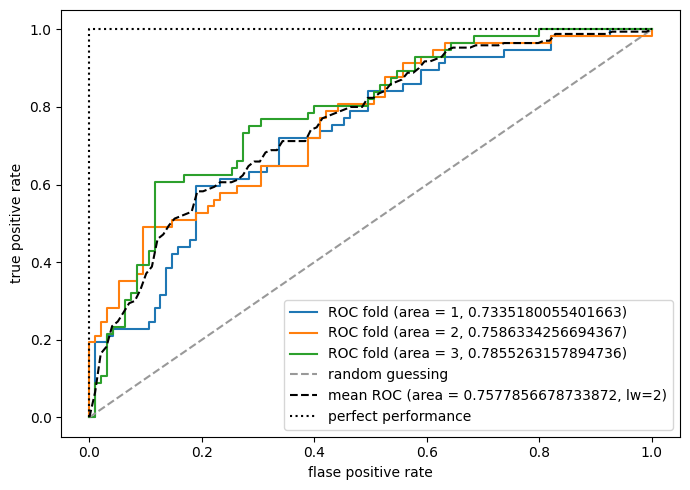

In [29]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2',
                       random_state=1,
                       C=100.0)
)

X_train2 = X_train[:, [4, 14]]

# cross validation
cv = list(
    StratifiedKFold(n_splits=3).split(X_train, y_train)
)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(
        y_train[test],
        probas[:, 1],
        pos_label=1
    )

    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f'ROC fold (area = {i+1}, {roc_auc})'
    )

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    color=(0.6, 0.6, 0.6),
    label='random guessing'
)

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'mean ROC (area = {mean_auc}, lw=2)')
plt.plot(
    [0, 0, 1],
    [0, 1, 1],
    linestyle=':',
    color='black',
    label='perfect performance'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

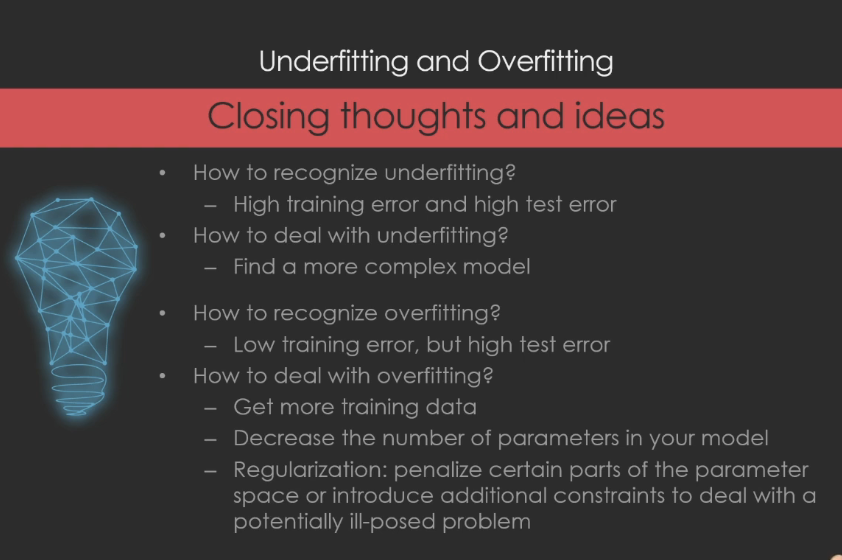

In [30]:
auc(0.167, 0.833)

InvalidParameterError: The 'x' parameter of auc must be an array-like. Got 0.167 instead.

In [31]:
auc(np.array([0, 0.167, 1]), np.array([0, 0.833, 1]))

0.833